# Test SimOOS Oracle

In [1]:
import os
os.chdir("../..")
os.getcwd()

'/Users/sbokupripeku/git/work/examples/costly_nonstationary_bandits'

In [2]:
%load_ext autoreload
%autoreload 2

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import time
import pickle

import algorithms
from src import evaluation
from src import costs
from plotting.costs import plot_costs

In [3]:
np.random.seed(42)

# Load the evaluation data saved in experiment 20

In [4]:
with open('dataset/nursery/nursery_evaluation.pickle', 'rb') as f:
    data = pickle.load(f)
    
all_contexts, all_rewards = data

In [5]:
all_contexts

,form,children,housing,finance,health
2,1,1,1,1,1
4,1,1,1,1,3
6,1,1,1,1,2
7,1,1,1,1,3
8,1,1,1,1,1
...,...,...,...,...,...
12952,4,4,3,2,3
12953,4,4,3,2,1
12955,4,4,3,2,3
12956,4,4,3,2,1


## Drop for debug and testing

In [6]:
all_contexts = all_contexts.drop(columns=['form', 'children'])

In [7]:
all_rewards

array([[1., 0., 0.],
       [0., 1., 0.],
       [0., 1., 0.],
       ...,
       [0., 0., 1.],
       [1., 0., 0.],
       [0., 0., 1.]])

## Set BETA parameter for the experiment

In [8]:
BETA = 1

# Adding non-stationarity


### Non-stationarity in rewards

In [9]:
all_rewards.shape[0]

10000

In [10]:
stationarity_regions = [
    slice(0, 500),
    slice(500, 1000),
    slice(1000, 2000),
    slice(2000, 3500),
    slice(3500, 5000),
    slice(5000, 6500),
    slice(6500, 8000),
    slice(8000, all_contexts.shape[0]),
]

In [11]:
change_point_values = [x.start for x in stationarity_regions] + [stationarity_regions[-1].stop]
change_point_values[0] += 1

In [12]:
change_point_values

[1, 500, 1000, 2000, 3500, 5000, 6500, 8000, 10000]

In [13]:
# We invert arm 0 with 2 and 1 with 3 (
np.mean(all_rewards, axis=0)

array([0.3396, 0.3366, 0.3238])

In [14]:
new_rewards = np.copy(all_rewards)
new_contexts = np.copy(all_contexts)

mean_rewards = np.zeros(new_rewards.shape)

n_arms = all_rewards.shape[1]

for i, region in enumerate(stationarity_regions):
    for arm_from in range(n_arms):
        # Cyclic shift of class labels
        arm_to = (arm_from + i) % n_arms
        if i > 0:
            new_rewards[region, arm_to] = all_rewards[region, arm_from]
        
        # For plotting
        mean_rewards[region, arm_to] = (
            np.ones(new_rewards[region, arm_to].shape) * np.mean(new_rewards[region, arm_to])
        )

In [15]:
new_contexts.shape, new_rewards.shape

((10000, 3), (10000, 3))

In [16]:
(new_rewards == all_rewards).all()

False

## Plot expected reward

Min expected reward for arm 1: 0.0
Min expected reward for arm 2: 0.022
Min expected reward for arm 3: 0.0


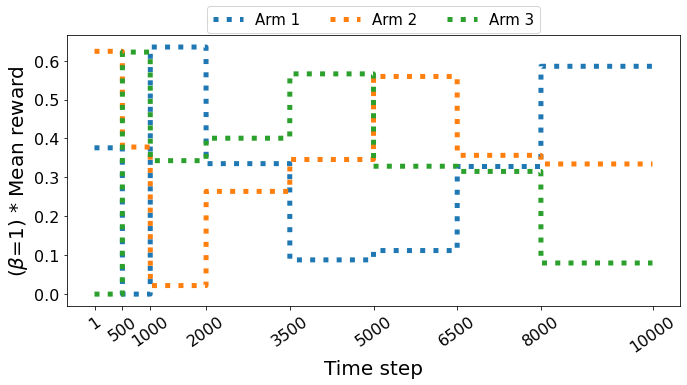

In [17]:
fig, ax = plt.subplots(1,1, figsize=(11,5))
for arm in range(n_arms):
    expected_gain = BETA * mean_rewards[:, arm] 
    ax.plot(expected_gain, label=f"Arm {arm+1}", linestyle=':', linewidth=5)
    print(f"Min expected reward for arm {arm+1}: {min(expected_gain)}")

    
extraticks = change_point_values
plt.xticks(extraticks, rotation=35, fontsize=16)

plt.yticks(fontsize=16)

ax.set_xlabel('Time step', fontsize=20)
ax.set_ylabel(fr"($\beta$={BETA}) * Mean reward", fontsize=20)

lgd = ax.legend(loc=9, ncol=5, bbox_to_anchor=(0.5, 1.132), prop={'size': 15})


plt.show()


### Non-stationarity in costs

In [18]:
cost_change_points = [3000, 5000, 7000, 9000]
interval_count = len(cost_change_points) + 1

In [19]:
cost_means_range = [0.05, 0.08]

In [20]:
COSTS_RANGE_SIZE = cost_means_range[1] - cost_means_range[0]

In [21]:
# Mean of gaussian distribution random in interval [0, 0.02] 
interval_means = [
    np.random.uniform(
        cost_means_range[0], cost_means_range[1], size=(new_contexts.shape[1],)
    ) for i in range(interval_count)
]

In [22]:
interval_means

[array([0.0612362 , 0.07852143, 0.07195982]),
 array([0.06795975, 0.05468056, 0.05467984]),
 array([0.05174251, 0.07598528, 0.06803345]),
 array([0.07124218, 0.05061753, 0.0790973 ]),
 array([0.07497328, 0.05637017, 0.05545475])]

In [23]:
# Fixed std
interval_stds = [[0.001]*new_contexts.shape[1]]*interval_count

In [24]:
def get_costs():
    return costs.NonstationaryGaussianCosts(
        feature_vector_size=new_contexts.shape[1],
        change_points=cost_change_points,
        interval_means=interval_means,
        interval_stds=interval_stds,
        random_seed=42,
    )
    

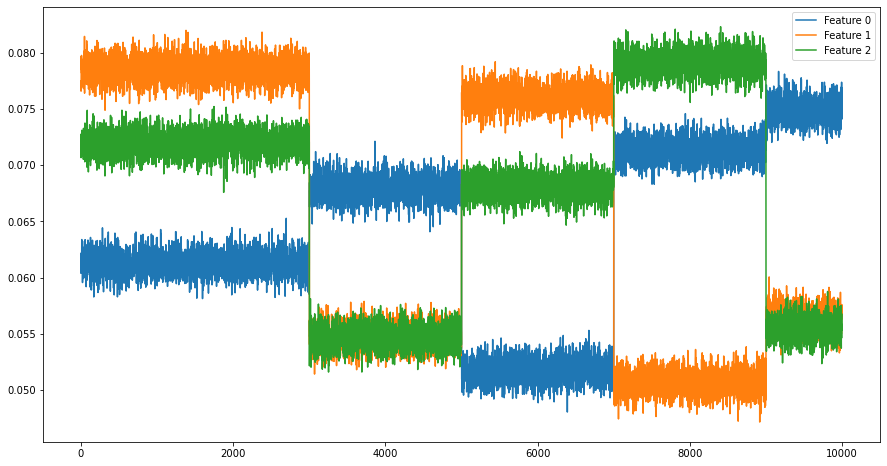

In [25]:
plot_costs(get_costs(), new_contexts.shape[0])

In [26]:
costs_obj = get_costs()

In [27]:
costs_vector = []
for t in range(new_contexts.shape[0]):
    costs_at_t = np.array(costs_obj.get_separate_costs(trial=t))
    costs_vector.append(costs_at_t)

costs_vector = np.stack(costs_vector)

In [28]:
costs_vector.shape

(10000, 3)

## Save mean costs for plotting

In [29]:
full_cost_change_points = [0] + cost_change_points + [new_contexts.shape[0]]
cost_stationarity_regions = []
for a, b in zip(full_cost_change_points, full_cost_change_points[1:]):
    cost_stationarity_regions.append(slice(a,b))

In [30]:
mean_costs = np.zeros(costs_vector.shape)
for i, region in enumerate(cost_stationarity_regions):
    for feature in range(new_contexts.shape[1]):
        
        # For plotting
        mean_costs[region, feature] = (
            np.ones(costs_vector[region, feature].shape) * interval_means[i][feature]
        )

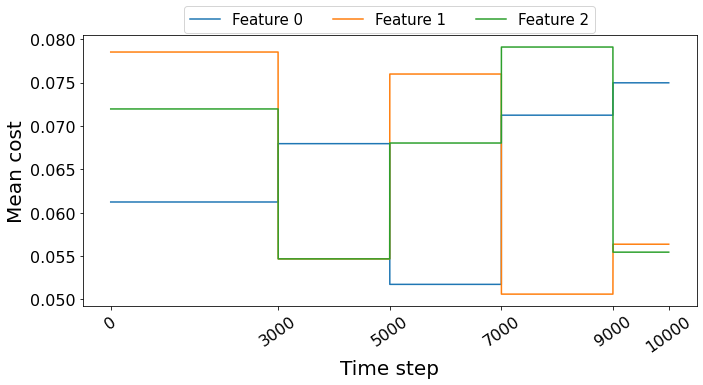

In [31]:
fig, ax = plt.subplots(1,1, figsize=(11,5))
for feature in range(new_contexts.shape[1]):
    ax.plot(mean_costs[:, feature], label=f"Feature {feature}")

extraticks = full_cost_change_points
plt.xticks(extraticks, rotation=35, fontsize=16)

plt.yticks(fontsize=16)

ax.set_xlabel('Time step', fontsize=20)
ax.set_ylabel(fr"Mean cost", fontsize=20)

lgd = ax.legend(loc=9, ncol=5, bbox_to_anchor=(0.5, 1.132), prop={'size': 15})

plt.show()

## Plot expected reward minus sum of costs

In [32]:
all_change_point_values = sorted(list(set(cost_change_points).union(set(change_point_values)) ))

Min expected gain for arm 1: -0.21684885205551502
Min expected gain for arm 2: -0.19448240998100796
Min expected gain for arm 3: -0.21704245380303566


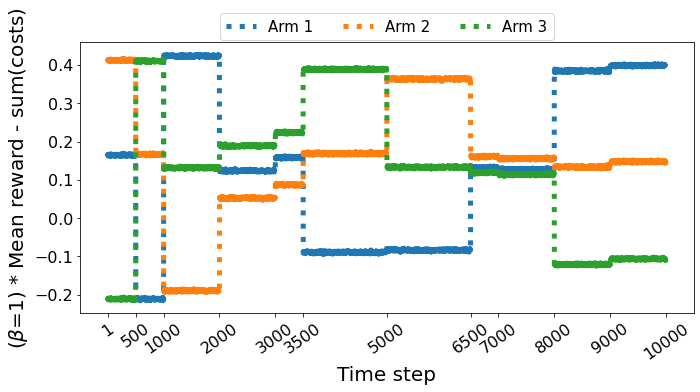

In [33]:
fig, ax = plt.subplots(1,1, figsize=(11,5))
for arm in range(n_arms):
    sum_of_costs = np.sum(costs_vector, axis=1)
    expected_gain = BETA * mean_rewards[:, arm] - sum_of_costs
    ax.plot(expected_gain, label=f"Arm {arm+1}", linestyle=':', linewidth=5)
    print(f"Min expected gain for arm {arm+1}: {min(expected_gain)}")

    
extraticks = all_change_point_values
plt.xticks(extraticks, rotation=35, fontsize=16)

plt.yticks(fontsize=16)

ax.set_xlabel('Time step', fontsize=20)
ax.set_ylabel(fr"($\beta$={BETA}) * Mean reward - sum(costs)", fontsize=20)

lgd = ax.legend(loc=9, ncol=5, bbox_to_anchor=(0.5, 1.132), prop={'size': 15})


plt.show()


In [34]:
def plot_gains(gain_dict, reward_change_points=()):
    fig, ax = plt.subplots(1,1, figsize=(15,8));
        
    
    
    ind_to_params = {
        # ind: (mark, color)
        0: ('x', 'k'),
        1: ('o','g'),
        2: ('s','r'),
        3: ('^','blue'),
        4: ('d','olive'),
        5: ('>', 'm'),
        6: ('*', 'c'),
        7: ('<', 'y'),
    }
    
    sorted_gain_dict = {
        k:v for k,v in sorted(gain_dict.items(), key=lambda x: x[1][-1], reverse=True)
    }
    
    
    max_vline=0
    
    for ind, (label, gain) in enumerate(sorted_gain_dict.items()):
        
        mark, color = ind_to_params[ind]
        ax.plot(gain, label=label, linestyle=':', marker=mark, markevery=750, fillstyle='none', color=color)
        max_vline=max(max_vline, max(gain))
    
    plt.vlines(reward_change_points, ymin=0, ymax=max_vline, linestyle=':', alpha=0.4)
    
    extraticks = all_change_point_values
    plt.xticks(extraticks, rotation=35, fontsize=16)
    plt.yticks(fontsize=16)
    
    ax.set_xlabel('Time step', fontsize=20)
    ax.set_ylabel('Cumulative gain', fontsize=20)
    


    plt.legend(prop={'size': 16});
    plt.show();

# Save stationarity regions

In [35]:
all_stationarity_regions = [(l, r) for l,r in zip(all_change_point_values, all_change_point_values[1:])]
N_STATIONARY_PERIODS = len(all_stationarity_regions)

In [36]:
all_stationarity_regions

[(1, 500),
 (500, 1000),
 (1000, 2000),
 (2000, 3000),
 (3000, 3500),
 (3500, 5000),
 (5000, 6500),
 (6500, 7000),
 (7000, 8000),
 (8000, 9000),
 (9000, 10000)]

## Testing Algorithm1oracle

In [37]:
NUM_OF_TRIALS = all_contexts.shape[0]
NUM_REPETITIONS = 1

In [38]:
np.random.seed(42)

In [39]:
gains_random = np.zeros((NUM_REPETITIONS, NUM_OF_TRIALS))

for i in range(NUM_REPETITIONS):
    p_random = algorithms.RandomPolicy()
    gain_random = evaluation.evaluate_on_synthetic_data(
        p_random,
        new_contexts,
        new_rewards,
        costs_vector,
        beta=BETA,
        stop_after=NUM_OF_TRIALS,
    )
    gains_random[i, :] = gain_random
    
gain_random = np.mean(gains_random, axis=0)
print(f"Average gain: {gain_random[-1]}")

Random policy
Beta = 1
Total gain: 3349.0
	Total reward: 3349.0
	Total cost: 0
Execution time: 0.1s
Average gain: 3349.0


In [40]:
gains_egreedy = np.zeros((NUM_REPETITIONS, NUM_OF_TRIALS))
for i in range(NUM_REPETITIONS):
    egreedy = algorithms.EpsilonGreedy(epsilon=0.03, n_arms=new_rewards.shape[1])

    gain_egreedy = evaluation.evaluate_on_synthetic_data(
        egreedy,
        new_contexts,
        new_rewards,
        costs_vector,
        beta=BETA,
        stop_after=NUM_OF_TRIALS,
    )
    gains_egreedy[i, :] = gain_egreedy
    
gain_egreedy = np.mean(gains_egreedy, axis=0)
print(f"Average gain: {gain_egreedy[-1]}")

E-greedy(epsilon=0.03)
Beta = 1
Total gain: 3816.0
	Total reward: 3816.0
	Total cost: 0
Execution time: 0.1s
Average gain: 3816.0


In [41]:
gains_ucb = np.zeros((NUM_REPETITIONS, NUM_OF_TRIALS))
for i in range(NUM_REPETITIONS):

    ucb_alg = algorithms.UCB1(
            n_trials=NUM_OF_TRIALS,
            n_arms=new_rewards.shape[1],
            alpha=0.6,
        )

    gain_ucb = evaluation.evaluate_on_synthetic_data(
        ucb_alg,
        new_contexts,
        new_rewards,
        costs_vector,
        beta=BETA,
        stop_after=NUM_OF_TRIALS,
    )
    gains_ucb[i, :] = gain_ucb

gain_ucb = np.mean(gains_ucb, axis=0)
print(f"Average gain: {gain_ucb[-1]}")

UCB1 (α=0.6)
Beta = 1
Total gain: 5177.0
	Total reward: 5177.0
	Total cost: 0
Execution time: 0.1s
Average gain: 5177.0


In [42]:
gains_linucb = np.zeros((NUM_REPETITIONS, NUM_OF_TRIALS))
for i in range(NUM_REPETITIONS):

    linucb = algorithms.LinUCB(
        n_trials=NUM_OF_TRIALS,
        context_dimension=new_contexts.shape[1],
        n_arms=new_rewards.shape[1],
        alpha=0.5,
    )
    gain_linucb = evaluation.evaluate_on_synthetic_data(
        linucb,
        new_contexts,
        new_rewards,
        costs_vector,
        beta=BETA,
        stop_after=NUM_OF_TRIALS,
    )
    gains_linucb[i, :] = gain_linucb

gain_linucb = np.mean(gains_linucb, axis=0)
print(f"Average gain: {gain_linucb[-1]}")

LinUCB (alpha=0.5)
Beta = 1
Total gain: 2047.7025058048396
	Total reward: 4018.0
	Total cost: 1970.297494195158
Execution time: 1.0s
Average gain: 2047.7025058048396


In [43]:
gains_pslinucb = np.zeros((NUM_REPETITIONS, NUM_OF_TRIALS))
for i in range(NUM_REPETITIONS):

    ps_linucb = algorithms.PSLinUCB(
        n_trials=NUM_OF_TRIALS,
        context_dimension=new_contexts.shape[1],
        n_arms=new_rewards.shape[1],
        alpha=0.7,
        omega=100,
        delta=0.05,
    )


    gain_pslinucb = evaluation.evaluate_on_synthetic_data(
        ps_linucb,
        new_contexts,
        new_rewards,
        costs_vector,
        beta=BETA,
        stop_after=NUM_OF_TRIALS,
    )
    change_points = ps_linucb.change_points
    gains_pslinucb[i, :] = gain_pslinucb

gain_pslinucb = np.mean(gains_pslinucb, axis=0)
print(f"Average gain: {gain_pslinucb[-1]}")

PSLinUCB (alpha=0.7, omega=100, delta=0.05)
Beta = 1
Total gain: 5132.702505804824
	Total reward: 7103.0
	Total cost: 1970.297494195158
Execution time: 1.8s
Average gain: 5132.702505804824


In [44]:
gains_simoos = np.zeros((NUM_REPETITIONS, NUM_OF_TRIALS))
for i in range(NUM_REPETITIONS):

    s = time.time()
    p_simoos = algorithms.SimOOSAlgorithm(
        all_contexts=new_contexts, 
        number_of_actions=new_rewards.shape[1],
        max_no_red_context=new_contexts.shape[1],
        beta_SimOOS=BETA,
        delta_SimOOS=0.005,
    )
    print(f"Took {time.time() - s} seconds")

    import warnings
    with warnings.catch_warnings():
        warnings.simplefilter("ignore")
        s = time.time()
        gain_simoos = evaluation.evaluate_on_synthetic_data(
            p_simoos,
            new_contexts[:NUM_OF_TRIALS],
            new_rewards[:NUM_OF_TRIALS],
            costs_vector[:NUM_OF_TRIALS],
            beta=BETA,
            stop_after=NUM_OF_TRIALS,
        )
        print(f"Took {time.time() - s} seconds")
    gains_simoos[i, :] = gain_simoos

gain_simoos = np.mean(gains_simoos, axis=0)
print(f"Average gain: {gain_simoos[-1]}")

Took 0.002076864242553711 seconds
Trial 0, time 2022-06-05 18:58:51.463148
Trial 500, time 2022-06-05 18:58:53.367975
Trial 1000, time 2022-06-05 18:58:54.030203
Trial 1500, time 2022-06-05 18:58:54.136611
Trial 2000, time 2022-06-05 18:58:54.630806
Trial 2500, time 2022-06-05 18:58:54.918649
Trial 3000, time 2022-06-05 18:58:55.432181
Trial 3500, time 2022-06-05 18:58:56.104164
Trial 4000, time 2022-06-05 18:58:56.663976
Trial 4500, time 2022-06-05 18:58:56.756375
Trial 5000, time 2022-06-05 18:58:56.828323
Trial 5500, time 2022-06-05 18:58:56.904357
Trial 6000, time 2022-06-05 18:58:57.001592
Trial 6500, time 2022-06-05 18:58:57.140906
Trial 7000, time 2022-06-05 18:58:57.422685
Trial 7500, time 2022-06-05 18:58:57.538207
Trial 8000, time 2022-06-05 18:58:57.726079
Trial 8500, time 2022-06-05 18:58:57.781292
Trial 9000, time 2022-06-05 18:58:57.825138
Trial 9500, time 2022-06-05 18:58:58.583735
SimOOS (beta=1, delta=0.005)
Beta = 1
Total gain: 4066.936865902432
	Total reward: 4783.0


In [45]:
costs_vector[0]

array([0.06154092, 0.07748145, 0.07271027])

In [46]:
gains_simoos_oracle = np.zeros((NUM_REPETITIONS, NUM_OF_TRIALS))
for i in range(NUM_REPETITIONS):

    s = time.time()
    p_simoos_oracle = algorithms.SimOOS_Oracle(
        all_contexts=new_contexts, 
        all_rewards=new_rewards,
        cost_vector=costs_vector[0],
        number_of_actions=new_rewards.shape[1],
        max_no_red_context=new_contexts.shape[1],
        beta_SimOOS=BETA,
    )
    print(f"Took {time.time() - s} seconds")

    import warnings
    with warnings.catch_warnings():
        warnings.simplefilter("ignore")
        s = time.time()
        gain_simoos_oracle = evaluation.evaluate_on_synthetic_data(
            p_simoos_oracle,
            new_contexts[:NUM_OF_TRIALS],
            new_rewards[:NUM_OF_TRIALS],
            costs_vector[:NUM_OF_TRIALS],
            beta=BETA,
            stop_after=NUM_OF_TRIALS,
        )
        print(f"Took {time.time() - s} seconds")
    gains_simoos_oracle[i, :] = gain_simoos_oracle

gain_simoos_oracle = np.mean(gains_simoos_oracle, axis=0)
print(f"Average gain: {gain_simoos_oracle[-1]}")

Took 0.05740809440612793 seconds
Trial 0, time 2022-06-05 18:58:59.203954
Trial 500, time 2022-06-05 18:58:59.209297
Trial 1000, time 2022-06-05 18:58:59.214586
Trial 1500, time 2022-06-05 18:58:59.220080
Trial 2000, time 2022-06-05 18:58:59.226342
Trial 2500, time 2022-06-05 18:58:59.233331
Trial 3000, time 2022-06-05 18:58:59.239146
Trial 3500, time 2022-06-05 18:58:59.245650
Trial 4000, time 2022-06-05 18:58:59.250529
Trial 4500, time 2022-06-05 18:58:59.256432
Trial 5000, time 2022-06-05 18:58:59.262609
Trial 5500, time 2022-06-05 18:58:59.268201
Trial 6000, time 2022-06-05 18:58:59.274123
Trial 6500, time 2022-06-05 18:58:59.278786
Trial 7000, time 2022-06-05 18:58:59.284398
Trial 7500, time 2022-06-05 18:58:59.290029
Trial 8000, time 2022-06-05 18:58:59.295647
Trial 8500, time 2022-06-05 18:58:59.301437
Trial 9000, time 2022-06-05 18:58:59.306862
Trial 9500, time 2022-06-05 18:58:59.314263
SimOOS-Oracle (beta=1)
Beta = 1
Total gain: 3481.0
	Total reward: 3481.0
	Total cost: 0
Exe

## Algorithm1 and Algorithm1-oracle

In [47]:
# gains_alg1 = np.zeros((NUM_REPETITIONS, NUM_OF_TRIALS))
# for i in range(NUM_REPETITIONS):

#     s = time.time()
#     p_alg1 = algorithms.Algorithm1(
#         all_contexts=new_contexts, 
#         number_of_actions=new_rewards.shape[1],
#         max_no_red_context=new_contexts.shape[1],
#         beta=BETA,
#         delta=0.04,
#         window_length=250,
#         costs_range=COSTS_RANGE_SIZE,
        
#     )
#     print(f"Took {time.time() - s} seconds")

#     import warnings
#     with warnings.catch_warnings():
#         warnings.simplefilter("ignore")
#         s = time.time()
#         gain_alg1 = evaluation.evaluate_on_synthetic_data(
#             p_alg1,
#             new_contexts[:NUM_OF_TRIALS],
#             new_rewards[:NUM_OF_TRIALS],
#             costs_vector[:NUM_OF_TRIALS],
#             beta=BETA,
#             stop_after=NUM_OF_TRIALS,
#         )
#         print(f"Took {time.time() - s} seconds")
#         gains_alg1[i, :] = gain_alg1

# gain_alg1 = np.mean(gains_alg1, axis=0)
# print(f"Average gain: {gain_alg1[-1]}")

In [48]:
all_stationarity_regions

[(1, 500),
 (500, 1000),
 (1000, 2000),
 (2000, 3000),
 (3000, 3500),
 (3500, 5000),
 (5000, 6500),
 (6500, 7000),
 (7000, 8000),
 (8000, 9000),
 (9000, 10000)]

In [49]:
costs_vector.shape

(10000, 3)

In [50]:
cost_means = np.zeros((N_STATIONARY_PERIODS, costs_vector.shape[1]))
for reg_num, region in enumerate(all_stationarity_regions):
    region_costs = costs_vector[slice(*region)]
    cost_means[reg_num, :] = region_costs.mean(axis=0)

In [52]:
gains_alg1_oracle = np.zeros((NUM_REPETITIONS, NUM_OF_TRIALS))
for i in range(NUM_REPETITIONS):

    s = time.time()
    p_alg1_oracle = algorithms.Algorithm1_Oracle(
        all_contexts=new_contexts, 
        all_rewards=new_rewards,
        cost_means=cost_means,
        stationarity_periods=all_stationarity_regions,
        number_of_actions=new_rewards.shape[1],
        max_no_red_context=new_contexts.shape[1],
        beta_SimOOS=BETA,
        
    )
    print(f"Took {time.time() - s} seconds")

    import warnings
    with warnings.catch_warnings():
        warnings.simplefilter("ignore")
        s = time.time()
        gain_alg1_oracle = evaluation.evaluate_on_synthetic_data(
            p_alg1_oracle,
            new_contexts[:NUM_OF_TRIALS],
            new_rewards[:NUM_OF_TRIALS],
            costs_vector[:NUM_OF_TRIALS],
            beta=BETA,
            stop_after=NUM_OF_TRIALS,
        )
        print(f"Took {time.time() - s} seconds")
        gains_alg1_oracle[i, :] = gain_alg1_oracle

gain_alg1_oracle = np.mean(gains_alg1_oracle, axis=0)
print(f"Average gain: {gain_alg1_oracle[-1]}")

Took 0.06426429748535156 seconds
Trial 0, time 2022-06-05 18:59:16.780036
Trial 500, time 2022-06-05 18:59:16.787591
Trial 1000, time 2022-06-05 18:59:16.794208
Trial 1500, time 2022-06-05 18:59:16.800945
Trial 2000, time 2022-06-05 18:59:16.807641
Trial 2500, time 2022-06-05 18:59:16.815322
Trial 3000, time 2022-06-05 18:59:16.823264
Trial 3500, time 2022-06-05 18:59:16.831186
Trial 4000, time 2022-06-05 18:59:16.839028
Trial 4500, time 2022-06-05 18:59:16.844654
Trial 5000, time 2022-06-05 18:59:16.852604
Trial 5500, time 2022-06-05 18:59:16.860845
Trial 6000, time 2022-06-05 18:59:16.868179
Trial 6500, time 2022-06-05 18:59:16.873704
Trial 7000, time 2022-06-05 18:59:16.881598
Trial 7500, time 2022-06-05 18:59:16.888588
Trial 8000, time 2022-06-05 18:59:16.895135
Trial 8500, time 2022-06-05 18:59:16.903109
Trial 9000, time 2022-06-05 18:59:16.911384
Trial 9500, time 2022-06-05 18:59:16.919105
Algorithm1-Oracle (beta=1)
Beta = 1
Total gain: 8189.128012135819
	Total reward: 8864.0
	To

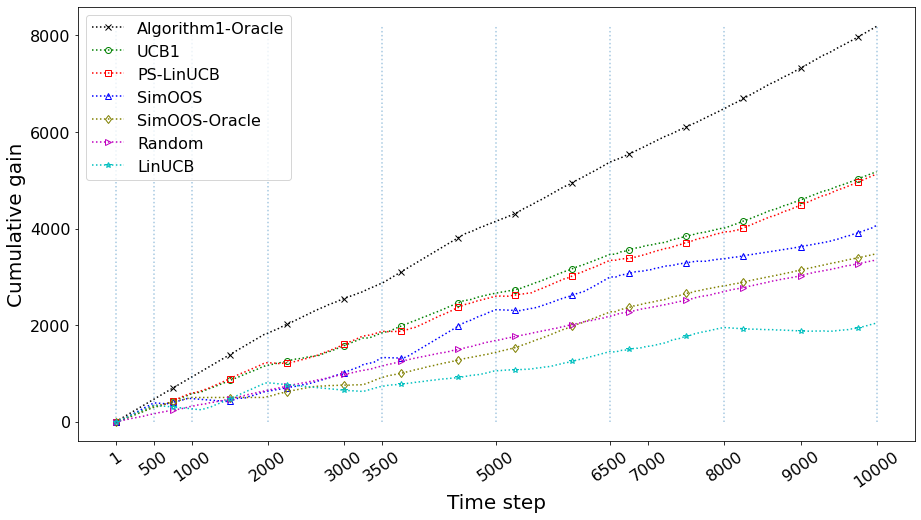

In [54]:
plot_gains(
    {
    'Random': gain_random,
    'UCB1': gain_ucb,
    'LinUCB': gain_linucb,
    'PS-LinUCB': gain_pslinucb,
    'SimOOS': gain_simoos,
    'SimOOS-Oracle': gain_simoos_oracle,
    'Algorithm1-Oracle': gain_alg1_oracle,
#     'Algorithm1': gain_alg1,
    },
    reward_change_points=change_point_values,
)


In [57]:
list(enumerate(new_rewards))

[(0, array([1., 0., 0.])),
 (1, array([0., 1., 0.])),
 (2, array([0., 1., 0.])),
 (3, array([0., 1., 0.])),
 (4, array([1., 0., 0.])),
 (5, array([0., 1., 0.])),
 (6, array([0., 1., 0.])),
 (7, array([1., 0., 0.])),
 (8, array([0., 1., 0.])),
 (9, array([0., 1., 0.])),
 (10, array([1., 0., 0.])),
 (11, array([1., 0., 0.])),
 (12, array([0., 1., 0.])),
 (13, array([0., 1., 0.])),
 (14, array([1., 0., 0.])),
 (15, array([0., 1., 0.])),
 (16, array([1., 0., 0.])),
 (17, array([0., 1., 0.])),
 (18, array([1., 0., 0.])),
 (19, array([0., 1., 0.])),
 (20, array([0., 1., 0.])),
 (21, array([1., 0., 0.])),
 (22, array([0., 1., 0.])),
 (23, array([1., 0., 0.])),
 (24, array([0., 1., 0.])),
 (25, array([0., 1., 0.])),
 (26, array([1., 0., 0.])),
 (27, array([1., 0., 0.])),
 (28, array([1., 0., 0.])),
 (29, array([0., 1., 0.])),
 (30, array([0., 1., 0.])),
 (31, array([0., 1., 0.])),
 (32, array([1., 0., 0.])),
 (33, array([0., 1., 0.])),
 (34, array([0., 1., 0.])),
 (35, array([1., 0., 0.])),
 (

In [60]:
list(enumerate(p_alg1_oracle.collected_costs_SimOOS))

[(0, 0.0727102694501486),
 (1, 0.07065763874747984),
 (2, 0.07194301709683787),
 (3, 0.0727376101897711),
 (4, 0.0724273275965942),
 (5, 0.07100093565351315),
 (6, 0.0717749558907969),
 (7, 0.07180528877227335),
 (8, 0.0724921274398955),
 (9, 0.07239063925735004),
 (10, 0.07144757552527062),
 (11, 0.07308879054706305),
 (12, 0.07113533703865091),
 (13, 0.07250297252264735),
 (14, 0.07207650406348289),
 (15, 0.07218341380311684),
 (16, 0.07224893765303214),
 (17, 0.07164014703798485),
 (18, 0.07168467600311547),
 (19, 0.07292809660893364),
 (20, 0.07212257131944716),
 (21, 0.07275316548954208),
 (22, 0.0728177941355993),
 (23, 0.07082653104033867),
 (24, 0.07210224399041272),
 (25, 0.07211835794541886),
 (26, 0.07241659349189956),
 (27, 0.07157808036034383),
 (28, 0.07149041591413943),
 (29, 0.0724063494303721),
 (30, 0.071536519942298),
 (31, 0.07051270578191907),
 (32, 0.07235959248106559),
 (33, 0.07325904655212821),
 (34, 0.07102620057433227),
 (35, 0.07162078517844159),
 (36, 0.072